# Preprocessing FoodSeg103 for YOLOv8
This notebook prepares the FoodSeg103 dataset for YOLOv8 segmentation training.

In [ ]:
import os
import shutil
from glob import glob
import random
from PIL import Image
import numpy as np
import cv2


import numpy as np
from tqdm import tqdm
from pathlib import Path

import yaml

## redimensionner les images et masques au format 640 x640

###     rassembler fichiers images et fichiers masques

In [126]:
import shutil
import yaml
from pathlib import Path

def rassembler_foodseg103_depuis_imagesets(root_source, root_dest, category_file="category_id.txt"):
    """
    Rassemble toutes les images et masques du dataset FoodSeg103 (à partir de train.txt et test.txt)
    et génère le fichier foodseg103.yaml pour YOLOv8.

    Args:
        root_source (str or Path): Racine du dataset contenant /Images/ et /ImageSets/
        root_dest (str or Path): Dossier cible (où seront créés /images, /masks, foodseg103.yaml)
        category_file (str): Nom (ou chemin) du fichier category_id.txt
    """
    root_source = Path(root_source)
    root_dest = Path(root_dest)
    img_out = root_dest / "images"
    msk_out = root_dest / "masks"
    img_out.mkdir(parents=True, exist_ok=True)
    msk_out.mkdir(parents=True, exist_ok=True)

    imagesets_dir = root_source / "ImageSets"
    img_dir = root_source / "Images" / "img_dir"
    ann_dir = root_source / "Images" / "ann_dir"

    total_found = 0
    total_missing = 0

    for split_file in ["train.txt", "test.txt"]:
        split_path = imagesets_dir / split_file
        if not split_path.exists():
            print(f"[!] Fichier manquant : {split_path}")
            continue

        with open(split_path, "r") as f:
            ids = [line.strip() for line in f if line.strip()]

        for img_name in ids:
            # img_name est déjà du type '00000000.jpg'
            mask_name = img_name.replace(".jpg", ".png")

            img_path = img_dir / "train" / img_name
            if not img_path.exists():
                img_path = img_dir / "test" / img_name

            ann_path = ann_dir / "train" / mask_name
            if not ann_path.exists():
                ann_path = ann_dir / "test" / mask_name

            if img_path.exists() and ann_path.exists():
                shutil.copy(img_path, img_out / img_name)
                shutil.copy(ann_path, msk_out / mask_name)
                total_found += 1
            else:
                print(f"[!] Fichiers manquants pour ID {img_name}")
                total_missing += 1

    print(f"\n✅ {total_found} paires image+masque copiées.")
    if total_missing:
        print(f"⚠️ {total_missing} paires manquantes (vérifie les IDs ou la structure).")

    # Création du fichier YAML
    category_path = Path(category_file)
    if not category_path.exists():
        category_path = root_source / category_file
    if not category_path.exists():
        print(f"[❌] Fichier category_id.txt introuvable : {category_path}")
        return

    class_names = []
    with open(category_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                class_name = " ".join(parts[1:])
                class_names.append(class_name)

    yaml_dict = {
        "path": str(root_dest),
        "train": "images",
        "val": "images",
        "test": "images",
        "names": {i: name for i, name in enumerate(class_names)}
    }

    yaml_path = root_dest / "foodseg103.yaml"
    with open(yaml_path, "w", encoding="utf-8") as f:
        yaml.dump(yaml_dict, f, allow_unicode=True)

    print(f"📄 YAML généré : {yaml_path}")


In [127]:
rassembler_foodseg103_depuis_imagesets(
    root_source=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\FoodSeg103",
    root_dest=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103"
)



✅ 7118 paires image+masque copiées.
📄 YAML généré : D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103\foodseg103.yaml


### resize image et masque to format yolo 640 x 640

In [161]:
import cv2
import yaml
from pathlib import Path

def resize_images_and_masks_to_640(input_dir, output_dir):
    """
    Redimensionne les images (.jpg) et masques (.png) à 640x640,
    et copie/adapte le fichier foodseg103.yaml avec chemins mis à jour.

    Args:
        input_dir (str or Path): Dossier contenant /images, /masks et foodseg103.yaml
        output_dir (str or Path): Nouveau dossier de sortie
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    img_in = input_dir / "images"
    msk_in = input_dir / "masks"
    img_out = output_dir / "images"
    msk_out = output_dir / "masks"

    img_out.mkdir(parents=True, exist_ok=True)
    msk_out.mkdir(parents=True, exist_ok=True)

    count_img = 0
    count_msk = 0

    for img_path in img_in.glob("*.jpg"):
        img = cv2.imread(str(img_path))
        if img is not None:
            resized = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)
            cv2.imwrite(str(img_out / img_path.name), resized)
            count_img += 1
        else:
            print(f"[!] Image illisible : {img_path.name}")

    for mask_path in msk_in.glob("*.png"):
        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
        if mask is not None:
            resized_mask = cv2.resize(mask, (640, 640), interpolation=cv2.INTER_NEAREST)
            cv2.imwrite(str(msk_out / mask_path.name), resized_mask)
            count_msk += 1
        else:
            print(f"[!] Masque illisible : {mask_path.name}")

    print(f"\n✅ {count_img} images redimensionnées → {img_out}")
    print(f"✅ {count_msk} masques redimensionnés → {msk_out}")

    # Copier et adapter le fichier YAML s’il existe
    yaml_in = input_dir / "foodseg103.yaml"
    if yaml_in.exists():
        with open(yaml_in, "r", encoding="utf-8") as f:
            data = yaml.safe_load(f)

        # Mise à jour des chemins
        data["path"] = str(output_dir)
        data["train"] = "images"
        data["val"] = "images"
        data["test"] = "images"

        yaml_out = output_dir / "foodseg103.yaml"
        with open(yaml_out, "w", encoding="utf-8") as f:
            yaml.dump(data, f, allow_unicode=True)

        print(f"📄 YAML mis à jour et copié vers : {yaml_out}")
    else:
        print("⚠️ Aucun fichier foodseg103.yaml trouvé à copier.")


In [162]:
resize_images_and_masks_to_640(
    input_dir=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103",
    output_dir=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize"
)



✅ 7118 images redimensionnées → D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize\images
✅ 7118 masques redimensionnés → D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize\masks
📄 YAML mis à jour et copié vers : D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize\foodseg103.yaml


### test visualisation (images + masque) tirage aleatoire de 5 images  

In [163]:
import cv2
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def visualiser_5_images_et_masques_avec_id(dataset_dir):
    """
    Affiche 5 images aléatoires avec superposition de leurs masques (et IDs visibles).
    Retourne un DataFrame avec image, class_ids et noms de classes (depuis le fichier YAML).
    """
    dataset_dir = Path(dataset_dir)
    img_dir = dataset_dir / "images"
    mask_dir = dataset_dir / "masks"
    yaml_path = dataset_dir / "foodseg103.yaml"

    if not yaml_path.exists():
        print("❌ Fichier foodseg103.yaml introuvable.")
        return pd.DataFrame()

    # Chargement des noms de classes depuis YAML
    with open(yaml_path, "r", encoding="utf-8") as f:
        class_names_dict = yaml.safe_load(f)["names"]

    class_names_dict = {int(k): v for k, v in class_names_dict.items()}
    all_images = sorted(img_dir.glob("*.jpg"))

    if len(all_images) < 5:
        print("❌ Moins de 5 images disponibles pour l'affichage.")
        return pd.DataFrame()

    selected = random.sample(all_images, 5)
    records = []

    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask_path = mask_dir / (img_path.stem + ".png")

        if not mask_path.exists():
            print(f"[!] Masque manquant pour {img_path.name}")
            continue

        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
        unique_ids = np.unique(mask)
        unique_ids = unique_ids[unique_ids != 0]  # exclure background

        img_display = img.copy()
        for cls_id in unique_ids:
            binary_mask = (mask == cls_id).astype(np.uint8)
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                if len(cnt) >= 3:
                    cv2.drawContours(img_display, [cnt], -1, (255, 255, 0), 1)
                    x, y = cnt[0][0]
                    label = f"{cls_id}: {class_names_dict.get(cls_id, 'unk')}"
                    cv2.putText(img_display, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img_display)
        plt.title(img_path.name)
        plt.axis("off")

        records.append({
            "image": img_path.name,
            "class_ids": list(map(int, unique_ids)),
            "class_names": [class_names_dict.get(int(cls), "unk") for cls in unique_ids]
        })

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(records)


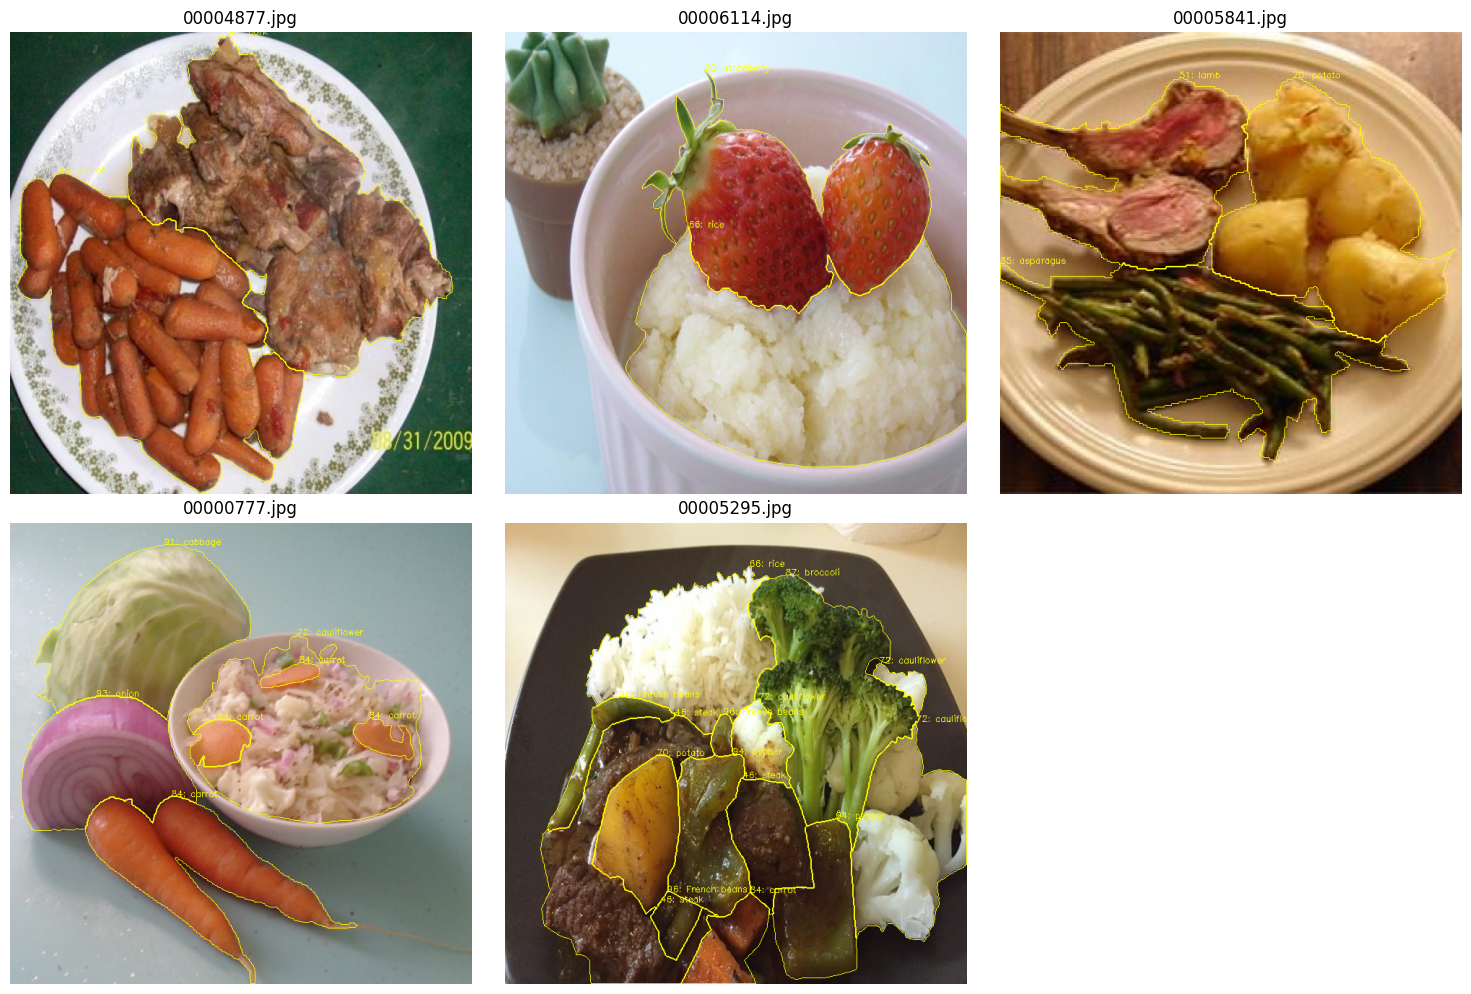

image                         class_ids  \
0  00004877.jpg                          [47, 84]   
1  00006114.jpg                          [30, 66]   
2  00005841.jpg                      [51, 70, 85]   
3  00000777.jpg                  [72, 84, 91, 93]   
4  00005295.jpg  [46, 66, 70, 72, 84, 87, 94, 96]   

                                         class_names  
0                                     [pork, carrot]  
1                                 [strawberry, rice]  
2                          [lamb, potato, asparagus]  
3              [cauliflower, carrot, cabbage, onion]  
4  [steak, rice, potato, cauliflower, carrot, bro...

In [164]:
df = visualiser_5_images_et_masques_avec_id(
    dataset_dir=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize"
)
df

## convert mask to txt file

In [181]:
import shutil
import cv2
import numpy as np
import yaml
from pathlib import Path
from tqdm import tqdm

def convert_masks_to_txt(root_source, output_dir):
    """
    Convertit des masques PNG (640x640) en fichiers .txt format YOLOv8.
    Copie aussi les images vers le dossier de destination.
    
    Args:
        root_source (str or Path): dossier contenant 'masks/', 'images/', 'foodseg103.yaml'
        output_dir (str or Path): dossier où seront copiés 'images/', créés 'labels/', et généré 'foodseg103.yaml'
    """
    root_source = Path(root_source)
    output_dir = Path(output_dir)
    mask_dir = root_source / "masks"
    img_dir = root_source / "images"
    label_dir = output_dir / "labels"
    image_out_dir = output_dir / "images"
    label_dir.mkdir(parents=True, exist_ok=True)
    image_out_dir.mkdir(parents=True, exist_ok=True)

    # 🔹 Charger les noms de classes
    yaml_path = root_source / "foodseg103.yaml"
    if not yaml_path.exists():
        print(f"[❌] Fichier YAML introuvable : {yaml_path}")
        return

    with open(yaml_path, "r", encoding="utf-8") as f:
        yaml_data = yaml.safe_load(f)
    class_names = yaml_data.get("names")
    if isinstance(class_names, dict):
        class_names = [class_names[i] for i in sorted(class_names.keys())]

    count_ok, count_skipped = 0, 0

    for mask_path in tqdm(sorted(mask_dir.glob("*.png")), desc="Conversion YOLOv8"):
        img_id = mask_path.stem
        img_path = img_dir / f"{img_id}.jpg"
        if not img_path.exists():
            print(f"[!] Image manquante : {img_path.name}")
            count_skipped += 1
            continue

        # Copier l'image dans le dossier de sortie
        shutil.copy(img_path, image_out_dir / img_path.name)

        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
        if mask is None:
            print(f"[!] Masque illisible : {mask_path.name}")
            count_skipped += 1
            continue

        if mask.ndim == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        h, w = mask.shape
        label_lines = []

        for cls_id in np.unique(mask):
            if cls_id == 0 or cls_id >= len(class_names):
                continue
            binary_mask = (mask == cls_id).astype(np.uint8)
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                if len(contour) < 3:
                    continue
                contour = contour.squeeze().astype(np.float32)
                contour[:, 0] /= w
                contour[:, 1] /= h
                coords = ' '.join(f"{v:.6f}" for v in contour.flatten())
                label_lines.append(f"{cls_id} {coords}")

        if label_lines:
            with open(label_dir / f"{img_id}.txt", "w") as f:
                f.write("\n".join(label_lines))
            count_ok += 1
        else:
            count_skipped += 1

    # 🔹 Génération du nouveau YAML
    yaml_out = {
        "path": str(output_dir.resolve()).replace("\\", "/"),
        "train": "images",
        "val": "images",
        "test": "images",
        "names": {i: name for i, name in enumerate(class_names)}
    }
    with open(output_dir / "foodseg103.yaml", "w", encoding="utf-8") as f:
        yaml.dump(yaml_out, f, allow_unicode=True)

    print(f"\n✅ Conversion terminée !")
    print(f"🟩 {count_ok} fichiers .txt générés")
    print(f"🟥 {count_skipped} ignorés ou vides")
    print(f"📁 Images copiées vers : {image_out_dir}")
    print(f"📁 Labels générés vers : {label_dir}")


In [182]:
convert_masks_to_txt(
    root_source=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize",
    output_dir=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt"
)

Conversion YOLOv8: 100%|██████████| 7118/7118 [02:28<00:00, 47.94it/s]


✅ Conversion terminée !
🟩 7118 fichiers .txt générés
🟥 0 ignorés ou vides
📁 Images copiées vers : D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt\images
📁 Labels générés vers : D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt\labels


## visualisation image et masque png et txt

In [187]:
import cv2
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def comparer_masques_png_vs_txt_images_aleatoires(
    img_dir,
    mask_png_dir,
    label_txt_dir,
    yaml_path,
    n=5
):
    """
    Tire aléatoirement `n` images, et compare visuellement :
    - leur masque PNG (image + contour rouge + id)
    - leur annotation YOLOv8 (image + polygone vert + id)
    
    Affiche côte à côte les versions PNG et TXT pour chaque image.

    Args:
        img_dir (str or Path): dossier contenant les .jpg
        mask_png_dir (str or Path): dossier contenant les .png (masques)
        label_txt_dir (str or Path): dossier contenant les .txt (annotations YOLOv8)
        yaml_path (str or Path): chemin vers le fichier foodseg103.yaml
        n (int): nombre d'images à tirer (par défaut : 5)

    Returns:
        pd.DataFrame: image, class_ids, class_names
    """
    img_dir = Path(img_dir)
    mask_png_dir = Path(mask_png_dir)
    label_txt_dir = Path(label_txt_dir)
    yaml_path = Path(yaml_path)

    if not yaml_path.exists():
        print("❌ Fichier foodseg103.yaml introuvable.")
        return pd.DataFrame()

    with open(yaml_path, "r", encoding="utf-8") as f:
        names_data = yaml.safe_load(f)["names"]
    class_names_dict = {int(k): v for k, v in names_data.items()} if isinstance(names_data, dict) else {i: v for i, v in enumerate(names_data)}

    all_images = sorted(img_dir.glob("*.jpg"))
    if len(all_images) < n:
        print("❌ Pas assez d'images disponibles.")
        return pd.DataFrame()

    selected = random.sample(all_images, n)
    df_records = []

    plt.figure(figsize=(12, n * 3))
    for idx, img_path in enumerate(selected):
        image_id = img_path.stem
        mask_path = mask_png_dir / f"{image_id}.png"
        txt_path = label_txt_dir / f"{image_id}.txt"

        if not mask_path.exists() or not txt_path.exists():
            print(f"[!] Fichier manquant pour {image_id}")
            continue

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        used_classes = set()

        # ➤ PNG overlay
        png_overlay = img.copy()
        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
        for cls_id in np.unique(mask):
            if cls_id == 0:
                continue
            binary_mask = (mask == cls_id).astype(np.uint8)
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                if len(cnt) >= 3:
                    cv2.drawContours(png_overlay, [cnt], -1, (255, 0, 0), 1)
                    x, y = cnt[0][0]
                    label = f"{cls_id}:{class_names_dict.get(cls_id, 'unk')}"
                    cv2.putText(png_overlay, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
                    used_classes.add(cls_id)

        # ➤ TXT overlay
        txt_overlay = img.copy()
        with open(txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 7:
                    continue
                cls_id = int(parts[0])
                coords = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(-1, 2)
                coords[:, 0] *= w
                coords[:, 1] *= h
                poly = coords.astype(np.int32)
                if len(poly) >= 3:
                    cv2.polylines(txt_overlay, [poly], isClosed=True, color=(0, 255, 0), thickness=1)
                    x, y = poly[0]
                    label = f"{cls_id}:{class_names_dict.get(cls_id, 'unk')}"
                    cv2.putText(txt_overlay, label, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
                    used_classes.add(cls_id)

        # ➤ Affichage
        plt.subplot(n, 2, idx * 2 + 1)
        plt.imshow(png_overlay)
        plt.title(f"{image_id} - PNG")
        plt.axis("off")

        plt.subplot(n, 2, idx * 2 + 2)
        plt.imshow(txt_overlay)
        plt.title(f"{image_id} - TXT")
        plt.axis("off")

        df_records.append({
            "image": image_id + ".jpg",
            "class_ids": sorted(used_classes),
            "class_names": [class_names_dict.get(c, "unk") for c in sorted(used_classes)]
        })

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(df_records)


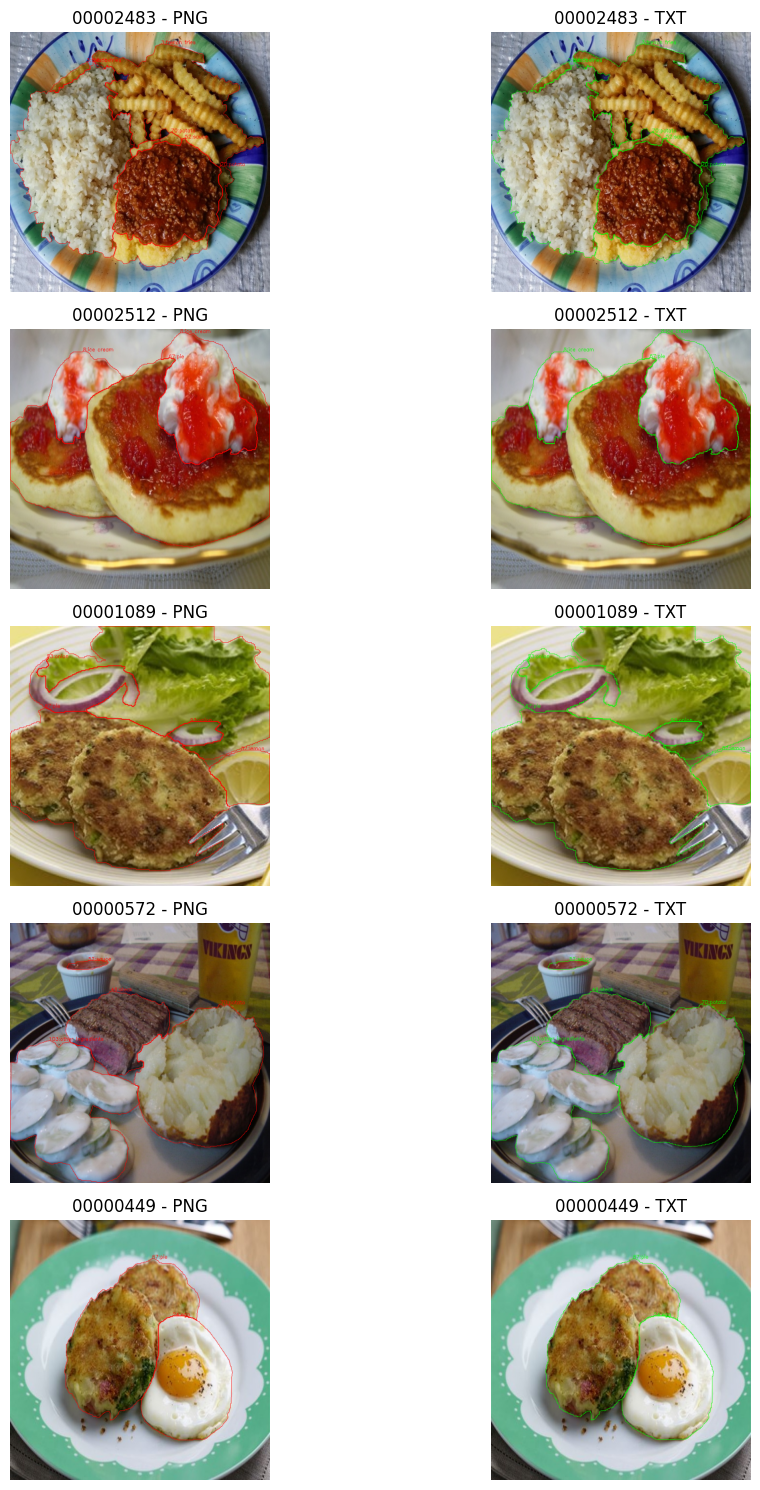

image          class_ids                                class_names
0  00002483.jpg    [3, 52, 66, 70]        [french fries, sauce, rice, potato]
1  00002512.jpg            [8, 67]                           [ice cream, pie]
2  00001089.jpg   [37, 67, 80, 93]               [lemon, pie, lettuce, onion]
3  00000572.jpg  [46, 52, 70, 103]  [steak, sauce, potato, other ingredients]
4  00000449.jpg           [24, 67]                                 [egg, pie]

In [189]:
df = comparer_masques_png_vs_txt_images_aleatoires(
    img_dir=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize\images",
    mask_png_dir=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize\masks",
    label_txt_dir=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt\labels",
    yaml_path=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt\foodseg103.yaml"
)
df

## representation des classes 

In [197]:
import os
import yaml
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(yaml_path):
    """
    Affiche la répartition en pourcentage des classes à partir d'un dataset YOLOv8
    où toutes les annotations sont dans un seul répertoire "labels/" (sans split).

    Args:
        yaml_path (str): Chemin vers le fichier .yaml du dataset YOLO
    """
    # Charger le fichier YAML
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    class_names = data.get('names', [])
    root_dir = os.path.dirname(yaml_path)

    # Trouver automatiquement le chemin vers les labels
    label_dir = os.path.join(root_dir, 'labels')
    if not os.path.exists(label_dir):
        print(f"[!] Le dossier 'labels/' est introuvable à {label_dir}")
        return

    # Compter les classes
    total_counts = Counter()
    for file in os.listdir(label_dir):
        if file.endswith('.txt'):
            with open(os.path.join(label_dir, file), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    total_counts[class_id] += 1

    total = sum(total_counts.values())
    if total == 0:
        print("Aucune annotation trouvée.")
        return

    # Calcul des pourcentages
    class_percentages = {k: (v / total * 100) for k, v in total_counts.items()}
    sorted_ids = sorted(class_percentages.keys())
    labels = [class_names[i] if class_names else str(i) for i in sorted_ids]
    values = [class_percentages[i] for i in sorted_ids]

    # Affichage
    plt.figure(figsize=(14, 6))
    plt.bar(labels, values)
    plt.ylabel("Pourcentage (%)")
    plt.xlabel("Classe")
    plt.title("Répartition des classes dans le dataset (format YOLOv8 sans split)")
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


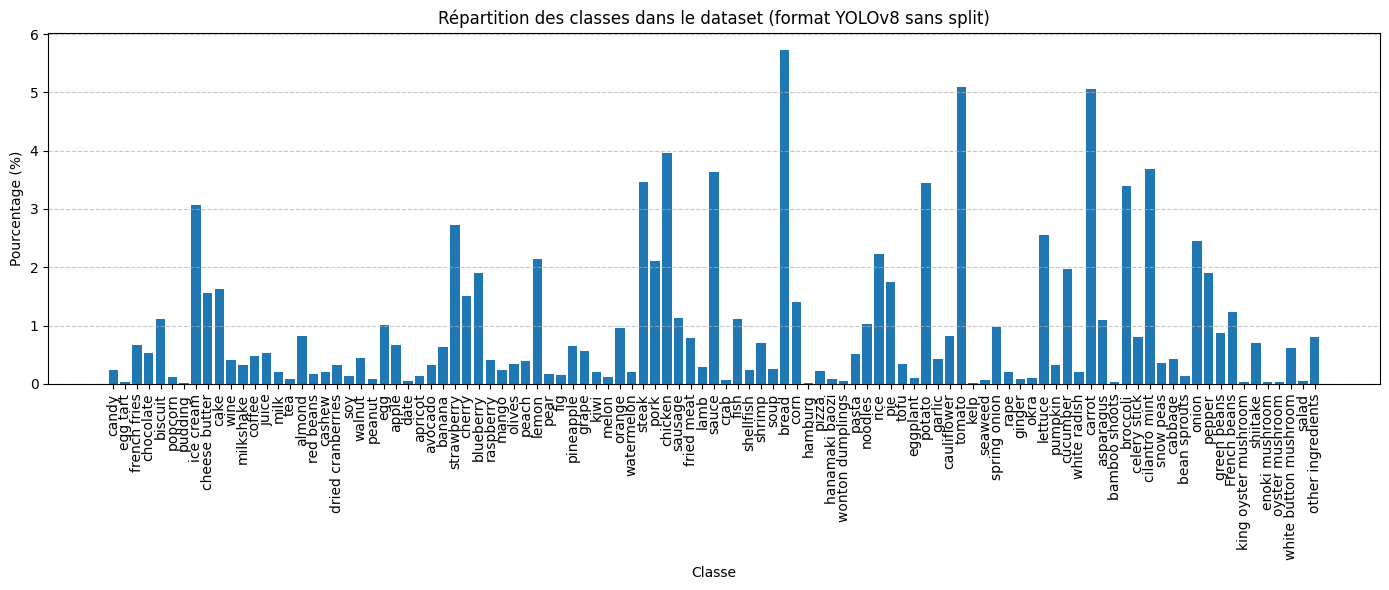

In [198]:
plot_class_distribution(r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt\foodseg103.yaml")


In [191]:
def summarize_class_distribution(yaml_path, threshold_percent=5.0):
    import pandas as pd

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    class_names = data['names']
    root_dir = os.path.dirname(yaml_path)
    train_dir = data['train']
    if not os.path.isabs(train_dir):
        train_dir = os.path.join(root_dir, train_dir)
    labels_dir = train_dir.replace('images', 'labels')

    class_counts = Counter()
    for file in os.listdir(labels_dir):
        if file.endswith('.txt'):
            with open(os.path.join(labels_dir, file), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    class_counts[class_id] += 1

    total = sum(class_counts.values())

    rows = []
    for i, name in enumerate(class_names):
        count = class_counts.get(i, 0)
        percent = (count / total) * 100 if total > 0 else 0
        is_rare = percent < threshold_percent
        rows.append({
            'class_id': i,
            'class_name': name,
            'count': count,
            'percent': round(percent, 2),
            'rare': is_rare
        })

    df = pd.DataFrame(rows).sort_values(by='percent', ascending=True)
    print(df.to_string(index=False))
    return df


In [194]:
df_stats = summarize_class_distribution(r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt\foodseg103.yaml", threshold_percent=2.0)
df_stats

 class_id  class_name  count  percent  rare
        0           0      0     0.00  True
        7           7      6     0.01  True
       74          74      7     0.02  True
       60          60      8     0.02  True
        2           2     11     0.03  True
       99          99     14     0.03  True
       86          86     15     0.04  True
       26          26     18     0.04  True
       97          97     15     0.04  True
      100         100     15     0.04  True
       63          63     20     0.05  True
      102         102     23     0.06  True
       75          75     26     0.06  True
       53          53     27     0.07  True
       62          62     34     0.08  True
       16          16     35     0.09  True
       23          23     36     0.09  True
       78          78     37     0.09  True
       69          69     42     0.10  True
       79          79     42     0.10  True
        6           6     45     0.11  True
       43          43     46    

class_id  class_name  count  percent   rare
0          0           0      0     0.00   True
7          7           7      6     0.01   True
74        74          74      7     0.02   True
60        60          60      8     0.02   True
2          2           2     11     0.03   True
..       ...         ...    ...      ...    ...
89        89          89   1490     3.69  False
48        48          48   1596     3.95  False
84        84          84   2040     5.05  False
73        73          73   2055     5.09  False
58        58          58   2315     5.73  False

[104 rows x 5 columns]

## DATA AUGMENTATION


In [74]:
def augment_rare_classes_segmentation_flat(yaml_path, threshold_percent=5.0, output_dir=None):
    import os
    import yaml
    import cv2
    import shutil
    from collections import Counter
    from tqdm import tqdm

    # Chargement YAML d'origine
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    class_names = data['names']
    root_dir = os.path.dirname(yaml_path)

    if output_dir is None:
        output_dir = os.path.join(root_dir, "augmented_dataset")
    os.makedirs(output_dir, exist_ok=True)

    # Copier images + labels dans output_dir
    image_src = os.path.join(root_dir, "images")
    label_src = os.path.join(root_dir, "labels")
    image_dst = os.path.join(output_dir, "images")
    label_dst = os.path.join(output_dir, "labels")
    shutil.copytree(image_src, image_dst, dirs_exist_ok=True)
    shutil.copytree(label_src, label_dst, dirs_exist_ok=True)
    print(f"✅ Dossier copié dans {output_dir}")

    # Comptage classes rares
    class_counts = Counter()
    for file in os.listdir(label_dst):
        if file.endswith('.txt'):
            with open(os.path.join(label_dst, file), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    class_counts[class_id] += 1

    total = sum(class_counts.values())
    rare_classes = [cls for cls, count in class_counts.items() if (count / total * 100) < threshold_percent]
    print(f"✅ Classes rares (<{threshold_percent}%): {[class_names[i] for i in rare_classes]}")

    transforms = [
        {'angle': 90},
        {'angle': 180},
        {'angle': 270},
        {'flip': 'horizontal'},
        {'flip': 'vertical'}
    ]
    possible_exts = ['.jpg', '.jpeg', '.png', '.JPG']

    for txt_file in tqdm(os.listdir(label_dst), desc="Augmentation"):
        if not txt_file.endswith('.txt'):
            continue

        txt_path = os.path.join(label_dst, txt_file)
        with open(txt_path, 'r') as f:
            lines = f.readlines()
        classes_in_file = {int(line.strip().split()[0]) for line in lines}

        if not all(cls in rare_classes for cls in classes_in_file):
            continue

        base_name = os.path.splitext(txt_file)[0]
        img_path = None
        for ext in possible_exts:
            test_path = os.path.join(image_dst, base_name + ext)
            if os.path.exists(test_path):
                img_path = test_path
                break
        if img_path is None:
            print(f"[!] Image introuvable pour {base_name}")
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"[!] Erreur de lecture : {img_path}")
            continue

        for i, tf in enumerate(transforms):
            angle = tf.get('angle')
            flip = tf.get('flip')
            aug_img = image.copy()

            if angle:
                if angle == 90:
                    aug_img = cv2.rotate(aug_img, cv2.ROTATE_90_CLOCKWISE)
                elif angle == 180:
                    aug_img = cv2.rotate(aug_img, cv2.ROTATE_180)
                elif angle == 270:
                    aug_img = cv2.rotate(aug_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            if flip:
                if flip == 'horizontal':
                    aug_img = cv2.flip(aug_img, 1)
                elif flip == 'vertical':
                    aug_img = cv2.flip(aug_img, 0)

            aug_labels = []
            for line in lines:
                parts = line.strip().split()
                cls = int(parts[0])
                coords = list(map(float, parts[1:]))

                new_coords = []
                for j in range(0, len(coords), 2):
                    x, y = coords[j], coords[j + 1]
                    if angle == 90:
                        x, y = 1 - y, x
                    elif angle == 180:
                        x, y = 1 - x, 1 - y
                    elif angle == 270:
                        x, y = y, 1 - x
                    if flip == 'horizontal':
                        x = 1 - x
                    if flip == 'vertical':
                        y = 1 - y
                    x = max(0.0, min(1.0, x))
                    y = max(0.0, min(1.0, y))
                    new_coords.extend([x, y])

                coords_str = ' '.join(f"{v:.6f}" for v in new_coords)
                aug_labels.append(f"{cls} {coords_str}")

            aug_base = f"{base_name}_aug{i}"
            cv2.imwrite(os.path.join(image_dst, f"{aug_base}.jpg"), aug_img)
            with open(os.path.join(label_dst, f"{aug_base}.txt"), 'w') as f_out:
                f_out.write('\n'.join(aug_labels))

    # Création du nouveau fichier YAML
    new_yaml = {
        "train": os.path.abspath(image_dst).replace("\\", "/"),
        "val": os.path.abspath(image_dst).replace("\\", "/"),
        "test": os.path.abspath(image_dst).replace("\\", "/"),
        "nc": len(class_names),
        "names": class_names
    }

    yaml_output_path = os.path.join(output_dir, "foodseg103.yaml")
    with open(yaml_output_path, 'w', encoding='utf-8') as f:
        yaml.dump(new_yaml, f, allow_unicode=True)

    print(f"\n✅ Augmentations terminées dans : {output_dir}/images et /labels")
    print(f"📄 Nouveau fichier YAML généré : {yaml_output_path}")


In [200]:
augment_rare_classes_segmentation_flat(
    yaml_path=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt\foodseg103.yaml",
    threshold_percent=3,
    output_dir=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug"
)


✅ Dossier copié dans D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug
✅ Classes rares (<3%): ['rice', 'snow peas', 'cucumber', 'onion', 'pie', 'asparagus', 'French beans', 'white button mushroom', 'sausage', 'corn', 'cheese butter', 'egg', 'strawberry', 'pork', 'green beans', 'biscuit', 'french fries', 'lettuce', 'garlic', 'fish', 'lemon', 'shellfish', 'spring onion', 'juice', 'pepper', 'other ingredients', 'cauliflower', 'pumpkin', 'apple', 'banana', 'orange', 'celery stick', 'blueberry', 'rape', 'noodles', 'soup', 'milk', 'fried meat', 'kiwi', 'shrimp', 'dried cranberries', 'pizza', 'avocado', 'hanamaki baozi', 'chocolate', 'cake', 'salad', 'grape', 'oyster mushroom', 'pineapple', 'lamb', 'coffee', 'cabbage', 'milkshake', 'peach', 'white radish', 'tea', 'ginger', 'wine', 'cherry', 'shiitake', 'mango', 'raspberry', 'pasta', 'pear', 'red beans', 'watermelon', 'candy', 'bean sprouts', 'date', 'pudding', 'melon', 'eggpl

Augmentation: 100%|██████████| 7118/7118 [00:48<00:00, 145.62it/s]


✅ Augmentations terminées dans : D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug/images et /labels
📄 Nouveau fichier YAML généré : D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug\foodseg103.yaml


### plot representation apres DATA augmentation

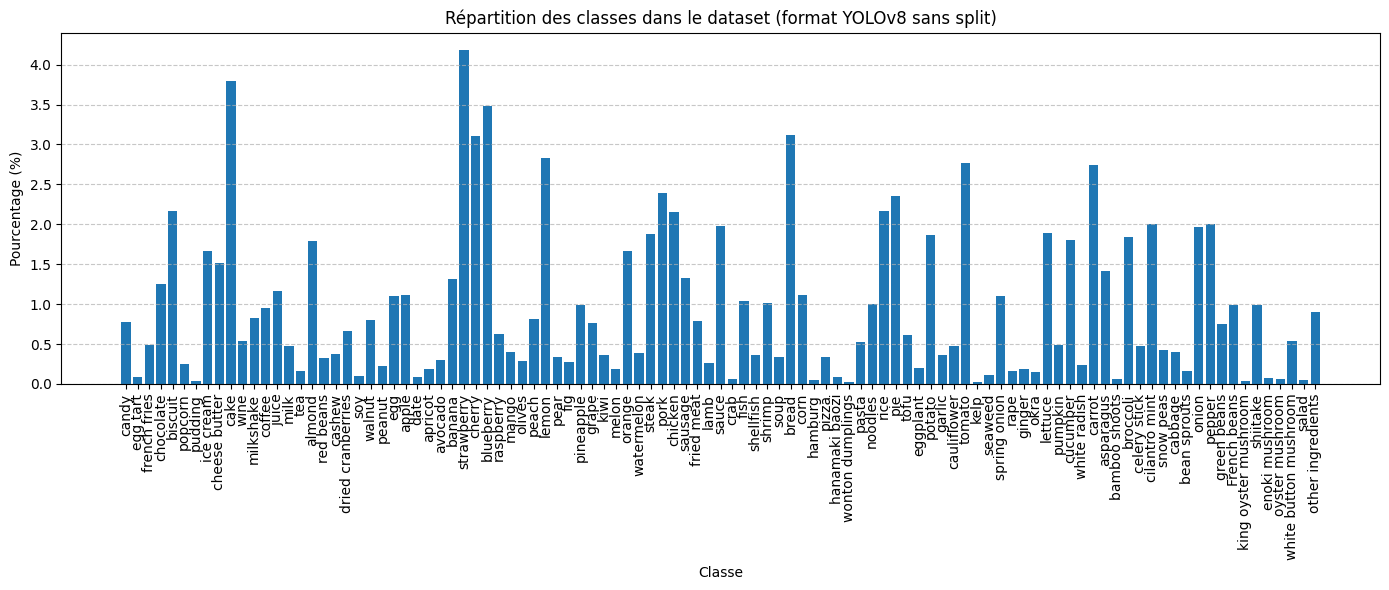

In [201]:
plot_class_distribution(r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug\foodseg103.yaml")


## verification data augmentation (visualisation)

In [202]:
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
import yaml
import pandas as pd

def visualiser_image_augmentee_et_variantes_flat(dataset_path):
    """
    Tire une image augmentée aléatoirement, puis affiche l'image originale et ses 5 augmentations
    avec les masques superposés et IDs visibles. Retourne un DataFrame résumant les classes.
    Fonction adaptée à une structure sans split (répertoire unique /images et /labels).
    """
    root = Path(dataset_path)
    img_dir = root / "images"
    lbl_dir = root / "labels"
    yaml_path = root / "foodseg103.yaml"

    # Charger les noms des classes
    with open(yaml_path, "r", encoding="utf-8") as f:
        class_names = yaml.safe_load(f)["names"]

    # Tirer une image augmentée aléatoire
    aug_images = sorted([f for f in img_dir.glob("*.jpg") if "_aug" in f.stem])
    if not aug_images:
        print("❌ Aucune image augmentée trouvée.")
        return pd.DataFrame()

    chosen_aug = random.choice(aug_images)
    base_name = chosen_aug.stem.split("_aug")[0]

    # Collecter original + augmentations
    all_versions = [(img_dir / f"{base_name}.jpg", lbl_dir / f"{base_name}.txt", "original")]
    for i in range(5):
        img_path = img_dir / f"{base_name}_aug{i}.jpg"
        lbl_path = lbl_dir / f"{base_name}_aug{i}.txt"
        if img_path.exists() and lbl_path.exists():
            all_versions.append((img_path, lbl_path, f"aug{i}"))

    if not all([p[0].exists() and p[1].exists() for p in all_versions]):
        print("❌ Une ou plusieurs images ou annotations sont manquantes.")
        return pd.DataFrame()

    # Affichage
    fig, axes = plt.subplots(1, len(all_versions), figsize=(4 * len(all_versions), 6))
    if len(all_versions) == 1:
        axes = [axes]

    records = []

    for idx, (img_path, lbl_path, tag) in enumerate(all_versions):
        img = Image.open(img_path)
        width, height = img.size
        ann_lines = lbl_path.read_text().strip().splitlines()

        ax = axes[idx]
        ax.imshow(img)
        ax.set_title(f"{tag}", fontsize=10)
        ax.axis("off")

        used_classes = set()

        for line in ann_lines:
            parts = line.strip().split()
            cls_id = int(parts[0])
            coords = np.array([float(x) for x in parts[1:]]).reshape(-1, 2)
            coords[:, 0] *= width
            coords[:, 1] *= height
            poly = plt.Polygon(coords, edgecolor='red', fill=False, linewidth=1)
            ax.add_patch(poly)

            x0, y0 = coords[0]
            ax.text(x0, y0, str(cls_id), fontsize=10, color='yellow',
                    bbox=dict(facecolor='black', edgecolor='yellow', boxstyle='round,pad=0.2'))
            used_classes.add(cls_id)

        class_ids = sorted(used_classes)
        class_labels = [class_names[c] if c < len(class_names) else f"id:{c}" for c in class_ids]

        records.append({
            "image": img_path.name,
            "augmentation": tag,
            "class_ids": class_ids,
            "class_names": class_labels
        })

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(records)


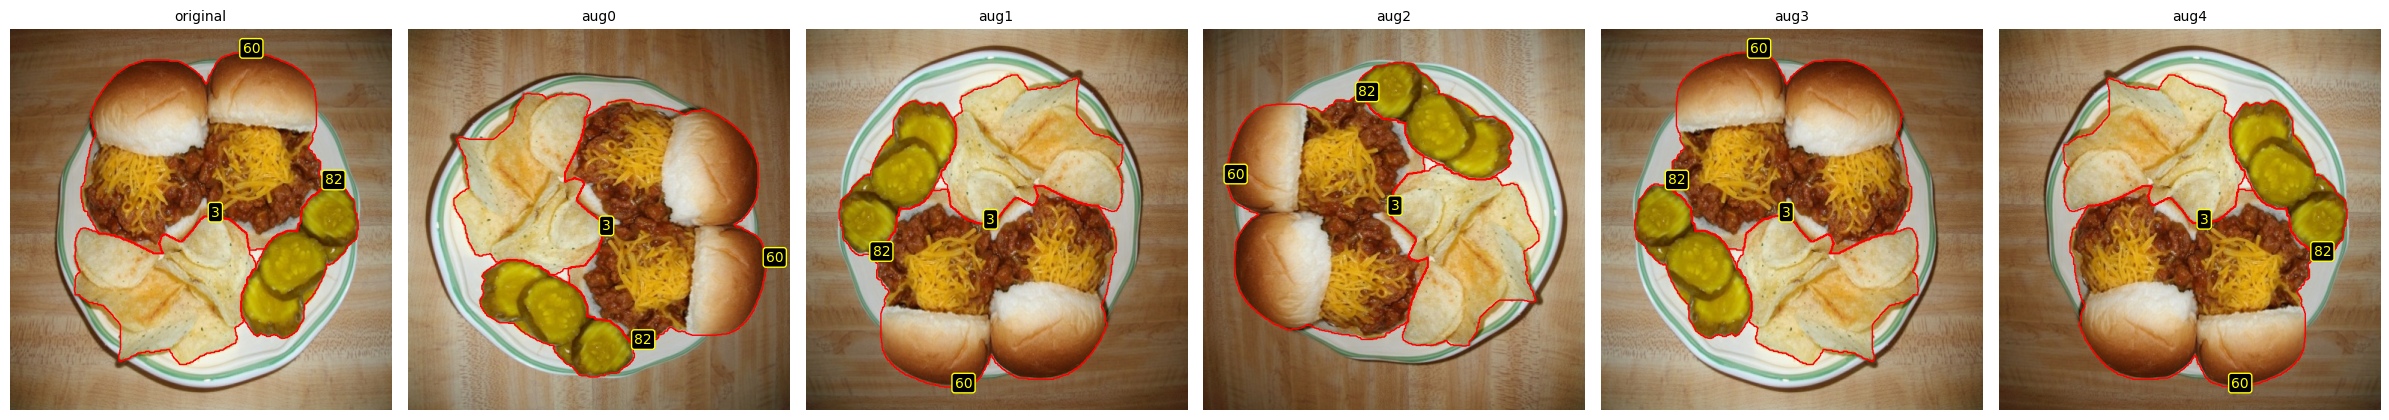

image augmentation    class_ids  \
0       00001819.jpg     original  [3, 60, 82]   
1  00001819_aug0.jpg         aug0  [3, 60, 82]   
2  00001819_aug1.jpg         aug1  [3, 60, 82]   
3  00001819_aug2.jpg         aug2  [3, 60, 82]   
4  00001819_aug3.jpg         aug3  [3, 60, 82]   
5  00001819_aug4.jpg         aug4  [3, 60, 82]   

                         class_names  
0  [french fries, hamburg, cucumber]  
1  [french fries, hamburg, cucumber]  
2  [french fries, hamburg, cucumber]  
3  [french fries, hamburg, cucumber]  
4  [french fries, hamburg, cucumber]  
5  [french fries, hamburg, cucumber]

In [209]:
df=visualiser_image_augmentee_et_variantes_flat(
    dataset_path=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug"
)
df

## split foodseg103_aug

In [207]:
import os
import shutil
import random
import yaml
from pathlib import Path

def split_dataset_yolo(root_source, root_dest, yaml_name="data.yaml", train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
    """
    Split un dataset YOLOv8 (dossier images/ + labels/) en train/val/test en copiant les fichiers
    et en générant un fichier YAML adapté dans le dossier destination.

    Args:
        root_source (str or Path): Dossier contenant les dossiers 'images/' et 'labels/' (non splittés)
        root_dest (str or Path): Dossier de destination contenant les splits et le YAML
        yaml_name (str): Nom du fichier yaml à générer (par défaut : data.yaml)
        train_ratio (float): proportion pour l'entraînement
        val_ratio (float): proportion pour la validation
        test_ratio (float): proportion pour le test
        seed (int): graine de tirage aléatoire
    """
    root_source = Path(root_source)
    root_dest = Path(root_dest)
    img_dir = root_source / "images"
    lbl_dir = root_source / "labels"

    output_img_dir = root_dest / "images"
    output_lbl_dir = root_dest / "labels"

    image_files = sorted([f for f in img_dir.glob("*.jpg")])
    paired = [(img, lbl_dir / f"{img.stem}.txt") for img in image_files if (lbl_dir / f"{img.stem}.txt").exists()]

    if not paired:
        print("❌ Aucun couple image/label trouvé.")
        return

    # Shuffle et split
    random.seed(seed)
    random.shuffle(paired)
    total = len(paired)
    n_train = int(train_ratio * total)
    n_val = int(val_ratio * total)
    n_test = total - n_train - n_val

    splits = {
        "train": paired[:n_train],
        "val": paired[n_train:n_train + n_val],
        "test": paired[n_train + n_val:]
    }

    for split_name, pairs in splits.items():
        split_img_dir = output_img_dir / split_name
        split_lbl_dir = output_lbl_dir / split_name
        split_img_dir.mkdir(parents=True, exist_ok=True)
        split_lbl_dir.mkdir(parents=True, exist_ok=True)

        for img_path, lbl_path in pairs:
            shutil.copy(img_path, split_img_dir / img_path.name)
            shutil.copy(lbl_path, split_lbl_dir / lbl_path.name)

        print(f"✅ {split_name}: {len(pairs)} fichiers copiés")

    # YAML
    yaml_data = {
        "train": str((output_img_dir / "train").resolve()).replace("\\", "/"),
        "val": str((output_img_dir / "val").resolve()).replace("\\", "/"),
        "test": str((output_img_dir / "test").resolve()).replace("\\", "/"),
        "nc": 0,
        "names": []
    }

    # Si un fichier YAML d’origine existe, recopier noms de classes
    original_yaml = root_source / "foodseg103.yaml"
    if original_yaml.exists():
        with open(original_yaml, "r", encoding="utf-8") as f:
            orig = yaml.safe_load(f)
        yaml_data["nc"] = orig.get("nc", 0)
        yaml_data["names"] = orig.get("names", [])

    with open(root_dest / yaml_name, "w", encoding="utf-8") as f:
        yaml.dump(yaml_data, f, allow_unicode=True)

    print(f"\n📁 Fichier YAML généré : {root_dest / yaml_name}")
    print(f"📦 Split total : {n_train} train, {n_val} val, {n_test} test — ({total} fichiers)")


In [208]:
split_dataset_yolo(
    root_source=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug",
    root_dest=r"D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug_split",
    yaml_name="foodseg103_aug.yaml",
    train_ratio=0.9,
    val_ratio=0.05,
    test_ratio=0.05
)


✅ train: 12773 fichiers copiés
✅ val: 709 fichiers copiés
✅ test: 711 fichiers copiés

📁 Fichier YAML généré : D:\jedha\full_stack\projet\projet_final\database\dataset_food103\food_dezip\FoodSeg103\yolo_foodseg103_resize_txt_aug_split\foodseg103_aug.yaml
📦 Split total : 12773 train, 709 val, 711 test — (14193 fichiers)
